## Imports


In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

## Load the data
Δεν καταφεραμε να κανουμε load τα ζητουμενα dataset,στο πως να κανουμε αντιστοιχηση των captions με τις εικονες τους.Οποτε συνεχισαμε με ενα απ τα ετοιμα dataset του tensoflow

In [3]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [8]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

κανουμε iterate μεσα στο dataset για να δουμε ποσες εικονες αντιστοιχουν σε υγειεις πνευμονες

In [24]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Healthy lungs count: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Lungs with pneumonia count: " + str(COUNT_PNEUMONIA))

Healthy lungs count: 1349
Lungs with pneumonia count: 3883


Παρατηρειται μεγαλη διαφορα μεταξυ των πνευμονων με πνευμονια απ' οτι τους υγειεις αρα το dataset μας ειναι  imbalanched, γεγονος που θα κληθουμε ισως να διορθωσουμε ωστε να πετυχουμε καλυτερα αποτελεσματα

In [5]:

def get_label(file_path):
    parts = tf.strings.split(file_path, "/")
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

Κανουμε split τα data σε training set και validation set
---



In [6]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

display of an (image, label) ζευγαρι.

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


## Visualize the dataset



In [9]:

def prepare_for_training(ds, cache=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


In [10]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

Συναρτηση για την οπτικοποιηση των εικονων 

In [11]:

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


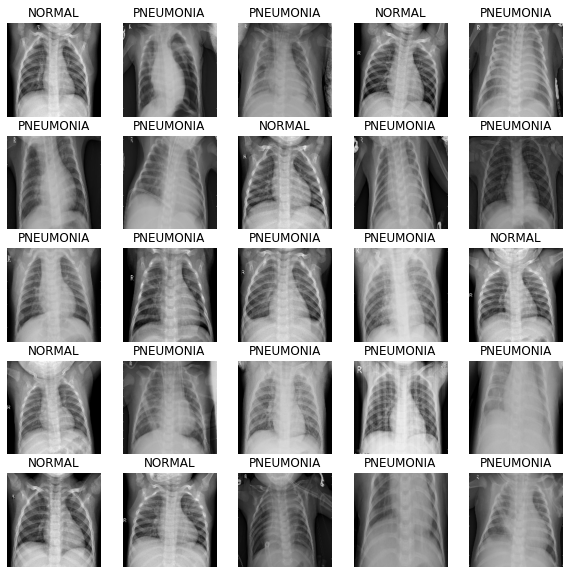

In [12]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Build the model

Το μοντελο που αντιστοιχει στην ομαδα μας ειναι το NasNetlarge

Η συναρτηση build model οριζει το μοντελο που θα χρησιμοποιηθει για την εκπαιδευση του deep learning δικτυου
Οι εικονες εχουν values sto (0,255) ιδανικα θα επρεπε να τις κανουμε scale στο (0,1) για να γινονται πιο ευκολα processed απ'το νευρωνικο δικτυο


In [35]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D

def build_model():
  nasnet = NASNetLarge(weights="imagenet", include_top=False,input_tensor=Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1])))

  outputs = nasnet.output()
  outputs = Flatten(name="flatten")(outputs)
  outputs = Dropout(0.4)(outputs)
  outputs = Dense(2, activation="softmax")(outputs)

  model = Model(inputs=nasnet.input, outputs=outputs)

  for layer in nasnet.layers:
    layer.trainable = False
  return model


## Balancing the dataset 

Οπως ειδαμε στην πρωτη φαση του iteration του dataset εχουμε πολλα παραπανω δατα στα οποια ο πνευμονας δεν ειναι υγειης .Θα διορθωσουμε λοιπον αυτη την ανισορροπια με χρηση class weighting:

In [15]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


## Train the model

### Defining callbacks


In [16]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

#Defining learning rate

In [17]:
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

### Fit the model


In [18]:
with strategy.scope():
    model = build_model()

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
168/168 [==============================] - 287s 1s/step - loss: 0.5230 - binary_accuracy: 0.7445 - precision: 0.9069 - recall: 0.7321 - val_loss: 13.8833 - val_binary_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 2/100
168/168 [==============================] - 194s 1s/step - loss: 0.3060 - binary_accuracy: 0.8745 - precision: 0.9600 - recall: 0.8676 - val_loss: 0.7485 - val_binary_accuracy: 0.7762 - val_precision: 0.9872 - val_recall: 0.7072
Epoch 3/100
168/168 [==============================] - 191s 1s/step - loss: 0.2404 - binary_accuracy: 0.9026 - precision: 0.9677 - recall: 0.8993 - val_loss: 0.8700 - val_binary_accuracy: 0.8014 - val_precision: 0.7941 - val_recall: 0.9882
Epoch 4/100
168/168 [==============================] - 190s 1s/step - loss: 0.2074 - binary_accuracy: 0.9145 - precision: 0.9743 - recall: 0.9092 - val_loss: 0.1286 - val_binary_accuracy: 0.9545 - val_precision: 0.9650 - val_recall: 0.9739
Epoch 5/100
168/168 [==================

## Evaluation



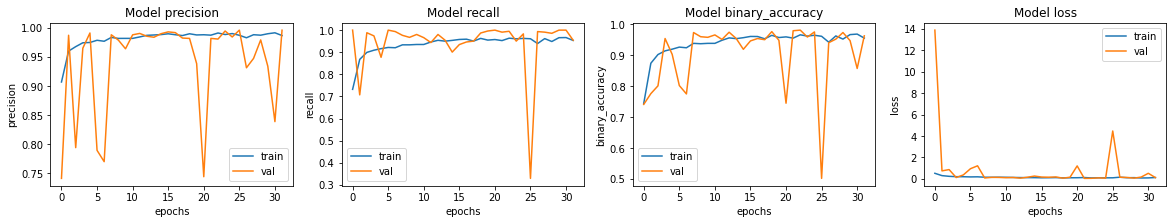

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## Predict and evaluate results



In [20]:
model.evaluate(test_ds, return_dict=True)

25/25 [==============================] - 14s 479ms/step - loss: 0.9949 - binary_accuracy: 0.7644 - precision: 0.7280 - recall: 0.9949


{'binary_accuracy': 0.7644230723381042,
 'loss': 0.9948949813842773,
 'precision': 0.7279549837112427,
 'recall': 0.9948717951774597}

Παρατηρουμε οτι το accuracy του test set ειναι μικροτερο απ'αυτο του validating set γεγονος που υποδηλωνει overfitting.

Το recall ειναι αρκετα καλυτερο απ' το preccision πραγμα που σημαινει οτι οσες εικονες εχουν προσδιοριστει ως μη υγειεις πνευμονες(με πνευμονια) εχουν σωστα προσδιοριστει.Για περαιτερω βελτιωση του νευρωνικου δικτυου θα επρπε να στοχευσουμε στην βελτιωση του precision

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  This is separate from the ipykernel package so we can avoid doing imports until


This image is 6.11 percent NORMAL
This image is 93.89 percent PNEUMONIA


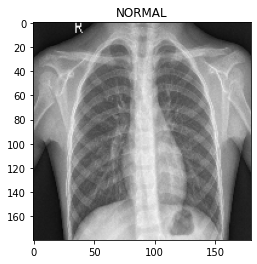

In [21]:
for image, label in test_ds.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))